# Statistical analysis of water discharge of surface streams

Large amounts of historical surface water data are available from the United States Geological Survey (USGS) at https://waterdata.usgs.gov/nwis The goal of the project is to retrieve samples from the web interface manually, and then later  automate the process by calling the web service as described at https://help.waterdata.usgs.gov/faq/automated-retrievals.

In [20]:
import os
import json
import pickle
import datetime
import numpy as np
import pandas as pd
import urllib.request
from scipy.signal import argrelextrema

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import clear_output, display

In [3]:
out = '.\\out\\'
figsave_format = 'pdf'
figsave_dpi = 200

colors = [
    'tab:red',
    'tab:orange',
    'tab:green',
    'tab:blue',
    'tab:purple'
]

# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

## Excercise 1

For the purposes of the current excercises, select a stream from a rainy area with relatively small discharge so that the effect of short but strong storms is visible. Good choices are small rivers from the north-eastern US, e.g. site 01589440. Retrieve at least 10 years of data.

In [4]:
# Fetch USGS surface water data from the following URL, written in easily readable format
#
# "Arguments":
#   - site_no    : Site number of choosen surface water(s)
#   - cb_X       : Identifier of requested data parameters
#   - period     : Measurement frequency
#   - begin_date : Lower lim. of the time interval of the fetched data
#   - end_date   : Upper lim. of the time interval of the fetched data
#   - format     : [rdb, json], format of the fetched datatable. Current
#                  code intents to support only 'rdb' (tab-separated) format
# Requested parameters in this instance:
# 00060  :  Discharge, cubic feet per second
# 00065  :  Gage height, feet
data_url = (
    'https://nwis.waterdata.usgs.gov/usa/nwis/uv/?' +
    'site_no=01585500' + '&' +
    'cb_00060=on' + '&' +
    'cb_00065=on' + '&' +
    'period=' + '&' +
    'begin_date=2008-01-01' + '&' +
    'end_date=2018-12-31' + '&' +
    'format=rdb'
)

In [5]:
data_url

'https://nwis.waterdata.usgs.gov/usa/nwis/uv/?site_no=01585500&cb_00060=on&cb_00065=on&period=&begin_date=2008-01-01&end_date=2018-12-31&format=rdb'

In [6]:
dump_fname = out + 'data.p'

# If pickled data exist, then load it
# Else fetch it from URL
if not os.path.exists(dump_fname):

    # The header of the 'rdb' formatted data files contain X+N lines of comments
    # in their headers, where
    #    - X : General notes, containing information about the fetched site(s)
    #    - N : Number of fetched data parameters (# of cb_X)
    # The first line after the comments is the actual header (column names) of the
    # data table.
    # There is also a trailing row after this line, which should be omitted.
    with urllib.request.urlopen(data_url) as url:
        data = pd.read_csv(url, sep='\t', comment='#', header=0, skiprows=[30], parse_dates=[2])
        
    with open(dump_fname, 'wb') as f:
        pickle.dump(data, f)

else:
    with open(dump_fname, 'rb') as f:
        data = pickle.load(f)

## Excercise 2

Load the downloaded data file into the processing environment paying attention to handling time stamps and perfoming the necessary data type conversions. Converting dates to floating point numbers such as unix time stamp or julian date usually makes handling time series easier. Plot the data for a certain interval to show that the effect of storms is clearly visible.

In [8]:
import matplotlib.dates as mdates

# FUTURE WARNING: EXPLICIT CONVERTER DECLARATION REQUIRED
# WHEN PLOTTING 'DATETIMES' FROM PANDAS DATAFRAMES
# USING MATPLOTLIB
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Format displayed ticks as years
years_fmt = mdates.DateFormatter('%Y')

### Discharge rates

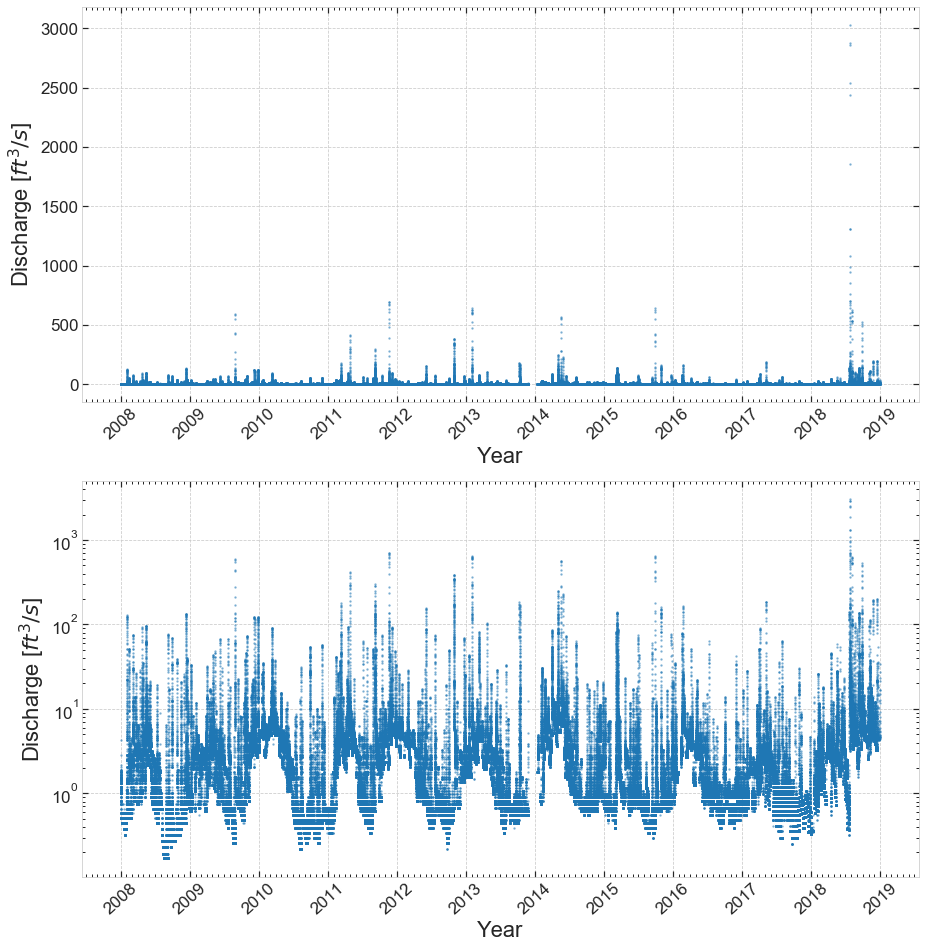

In [9]:
nrows = 2
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*15, nrows*8))

axisticksize = 17
axislabelsize = 22
scattersize = 1.5

axes[0].scatter(data['datetime'], data['69679_00060'],
                c='tab:blue', s=scattersize**2, alpha=0.4)

axes[1].scatter(data['datetime'], data['69679_00060'],
                c='tab:blue', s=scattersize**2, alpha=0.4)
axes[1].set_yscale('log')

for i in range(nrows):
    axes[i].set_xlabel('Year', fontsize=axislabelsize)
    axes[i].set_ylabel('Discharge [$ft^{3}/s$]', fontsize=axislabelsize)
    axes[i].tick_params(axis='both', which='major', labelsize=axisticksize)

    # Rotate dates on axis
    axes[i].tick_params(axis='x', which='major', rotation=42)

    # DATE FORMATTING SOURCE:
    #   - https://matplotlib.org/gallery/text_labels_and_annotations/date.html
    # Format the ticks by calling the locator instances of matplotlib.dates
    axes[i].xaxis.set_major_locator(mdates.YearLocator())
    axes[i].xaxis.set_major_formatter(years_fmt)
    axes[i].xaxis.set_minor_locator(mdates.MonthLocator())
    
plt.show()

#### Split dataset into N equal slices

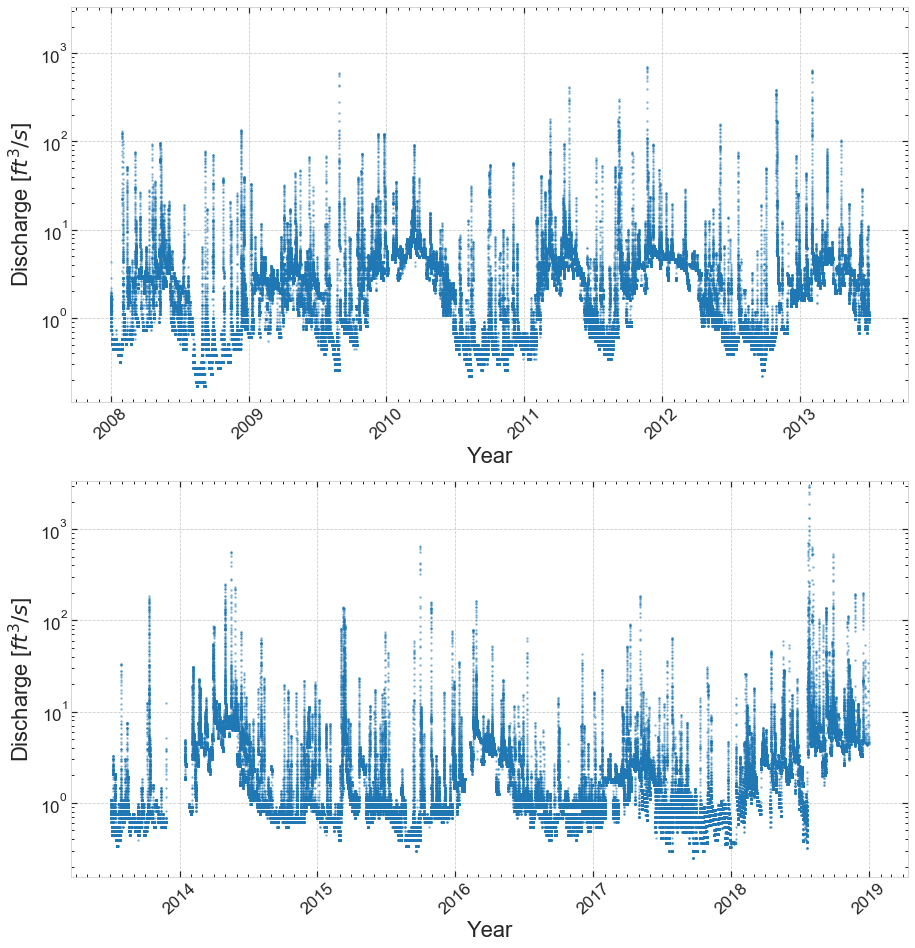

In [10]:
nrows = 2
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*15, nrows*8))

axisticksize = 17
axislabelsize = 22
scattersize = 1.5

dt = data['datetime'].max() - data['datetime'].min()
ts0 = data['datetime'].min()
split = dt//nrows

for i in range(nrows):
    tsB = ts0 + i * split
    tsE = ts0 + (i+1) * split
    current_data = data[(data.datetime >= tsB) & (data.datetime < tsE)]
    axes[i].scatter(current_data['datetime'], current_data['69679_00060'],
                    c='tab:blue', s=scattersize**2, alpha=0.4)
    axes[i].set_yscale('log')
    axes[i].set_ylim(None, 1.1 * data['69679_00060'].max())

    axes[i].set_xlabel('Year', fontsize=axislabelsize)
    axes[i].set_ylabel('Discharge [$ft^{3}/s$]', fontsize=axislabelsize)
    axes[i].tick_params(axis='both', which='major', labelsize=axisticksize)

    # Rotate dates on axis
    axes[i].tick_params(axis='x', which='major', rotation=42)
    
    # DATE FORMATTING SOURCE:
    #   - https://matplotlib.org/gallery/text_labels_and_annotations/date.html
    # Format the ticks by calling the locator instances of matplotlib.dates
    # These locators should be called for every axis, that's why
    # they're placed inside this loop
    axes[i].xaxis.set_major_locator(mdates.YearLocator())
    axes[i].xaxis.set_major_formatter(years_fmt)
    axes[i].xaxis.set_minor_locator(mdates.MonthLocator())

plt.show()

### Gage height

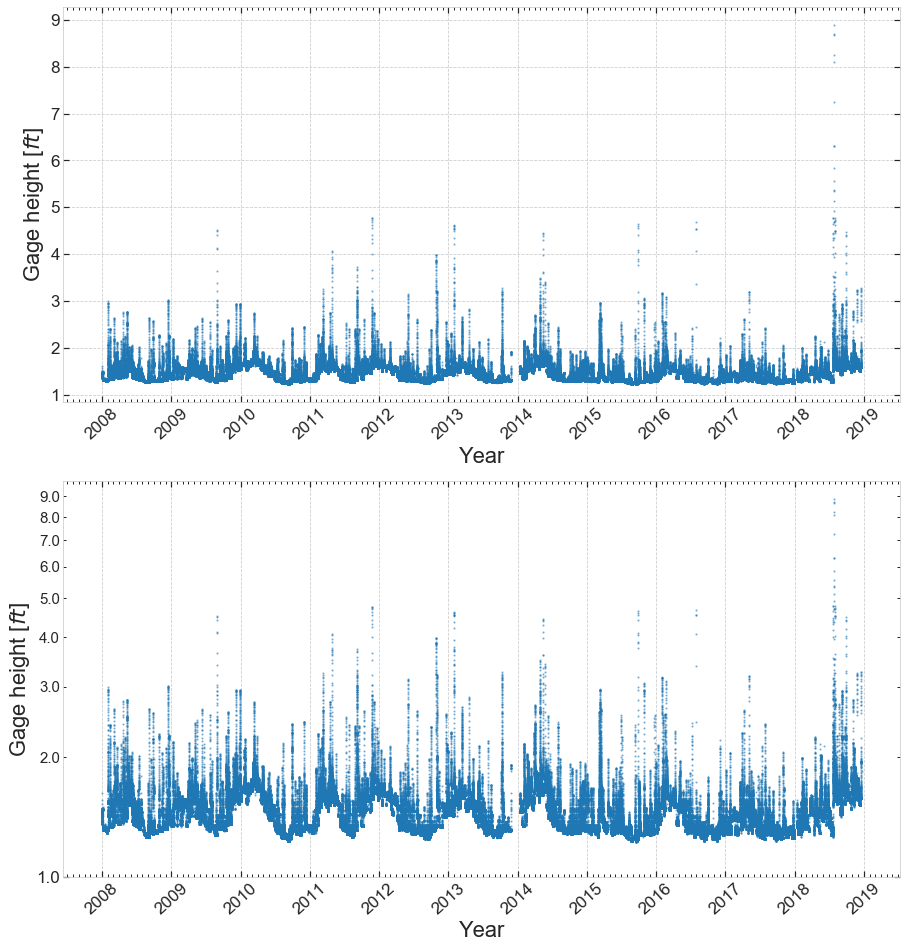

In [11]:
nrows = 2
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*15, nrows*8))

axisticksize = 17
axislabelsize = 22
scattersize = 1.3

axes[0].scatter(data['datetime'], data['69680_00065'],
                c='tab:blue', s=scattersize**2, alpha=0.4)

axes[1].scatter(data['datetime'], data['69680_00065'],
                c='tab:blue', s=scattersize**2, alpha=0.4)
axes[1].set_yscale('log')

for i in range(nrows):
    axes[i].set_xlabel('Year', fontsize=axislabelsize)
    axes[i].set_ylabel('Gage height [$ft$]', fontsize=axislabelsize)
    axes[i].tick_params(axis='both', which='major', labelsize=axisticksize)
    axes[i].tick_params(axis='both', which='minor', labelsize=axisticksize-2)

    # Rotate dates on axis
    axes[i].tick_params(axis='x', which='major', rotation=42)
    
    # DATE FORMATTING SOURCE:
    #   - https://matplotlib.org/gallery/text_labels_and_annotations/date.html
    # Format the ticks by calling the locator instances of matplotlib.dates
    axes[i].xaxis.set_major_locator(mdates.YearLocator())
    axes[i].xaxis.set_major_formatter(years_fmt)
    axes[i].xaxis.set_minor_locator(mdates.MonthLocator())
    
    if i == 1:
        axes[i].set_ylim(1, None)
        # Turn off scientific notations, which looked here unbearingly retarded
        # Pretty much helpful thread:
        #   - https://stackoverflow.com/questions/21920233/
        axes[i].yaxis.set_major_formatter(mticker.ScalarFormatter())
        axes[i].yaxis.set_minor_formatter(mticker.ScalarFormatter())
    
plt.show()

#### Split dataset into N equal slices

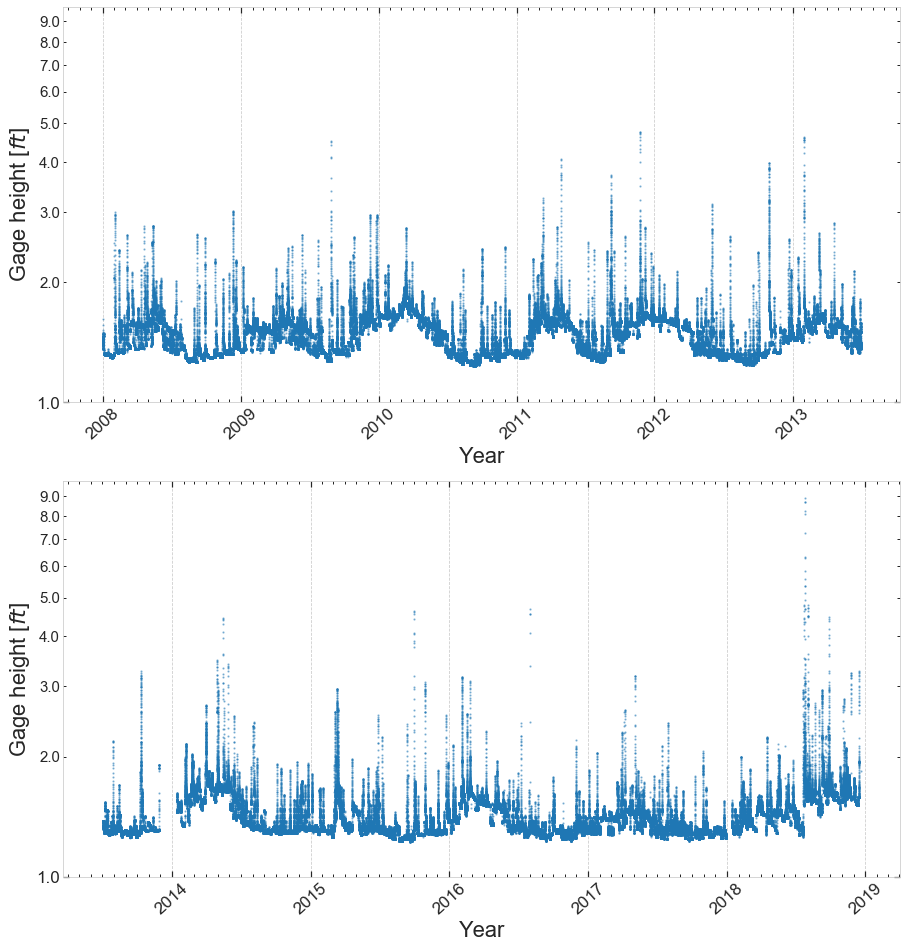

In [12]:
nrows = 2
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*15, nrows*8))

axisticksize = 17
axislabelsize = 22
scattersize = 1.3

# Sliceing the data into equal time intervals
dt = data['datetime'].max() - data['datetime'].min()
ts0 = data['datetime'].min()
split = dt//nrows

for i in range(nrows):
    tsB = ts0 + i * split
    tsE = ts0 + (i+1) * split
    current_data = data[(data.datetime >= tsB) & (data.datetime < tsE)]
    axes[i].scatter(current_data['datetime'], current_data['69680_00065'],
                    c='tab:blue', s=scattersize**2, alpha=0.4)
    axes[i].set_yscale('log')
    axes[i].set_ylim(1, 1.1 * data['69680_00065'].max())

    axes[i].set_xlabel('Year', fontsize=axislabelsize)
    axes[i].set_ylabel('Gage height [$ft$]', fontsize=axislabelsize)
    axes[i].tick_params(axis='both', which='major', labelsize=axisticksize)
    axes[i].tick_params(axis='both', which='minor', labelsize=axisticksize-2)

    # Rotate dates on axis
    axes[i].tick_params(axis='x', which='major', rotation=42)
    
    # DATE FORMATTING SOURCE:
    #   - https://matplotlib.org/gallery/text_labels_and_annotations/date.html
    # Format the ticks by calling the locator instances of matplotlib.dates
    axes[i].xaxis.set_major_locator(mdates.YearLocator())
    axes[i].xaxis.set_major_formatter(years_fmt)
    axes[i].xaxis.set_minor_locator(mdates.MonthLocator())
    
    # Turn off scientific notations, which looked here "unbearingly" retarded
    # Pretty much helpful thread:
    #   - https://stackoverflow.com/questions/21920233/
    axes[i].yaxis.set_major_formatter(mticker.ScalarFormatter())
    axes[i].yaxis.set_minor_formatter(mticker.ScalarFormatter())

plt.show()

## Excercise 3

Plot the histogram of water discharge values. Fit the data with an appropriate distribution function and bring arguments in favor of the choice of function.

c:\program files\python38\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\program files\python38\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


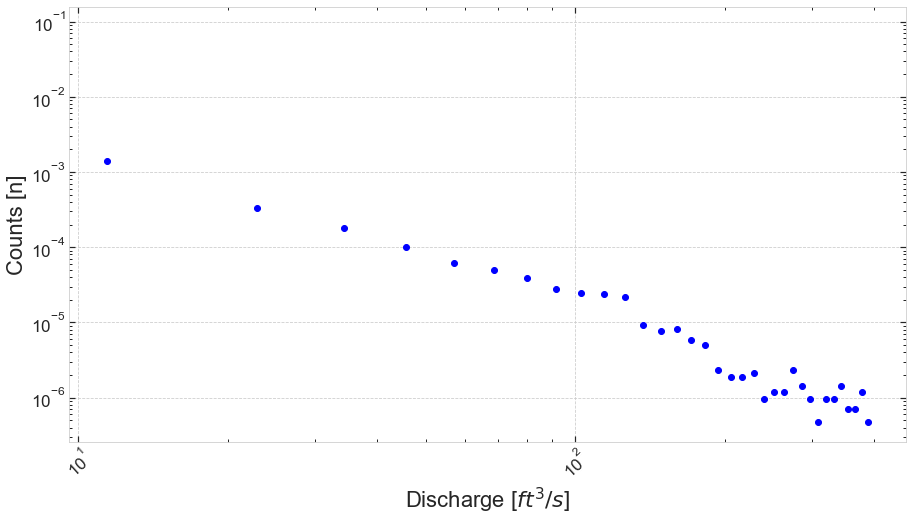

In [13]:
nrows = 1
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*15, nrows*8))

axisticksize = 17
axislabelsize = 22
scattersize = 1.3

hist, bins = np.histogram(data['69679_00060'], bins=35, range=(0,400), density=True)
axes.loglog(bins[:-1], hist, 'bo')

axes.set_xlabel('Discharge [$ft^{3}/s$]', fontsize=axislabelsize)
axes.set_ylabel('Counts [n]', fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axisticksize)
axes.tick_params(axis='both', which='minor', labelsize=axisticksize-2)

# Rotate dates on axis
axes.tick_params(axis='x', which='major', rotation=42)

plt.show()

### Phase space

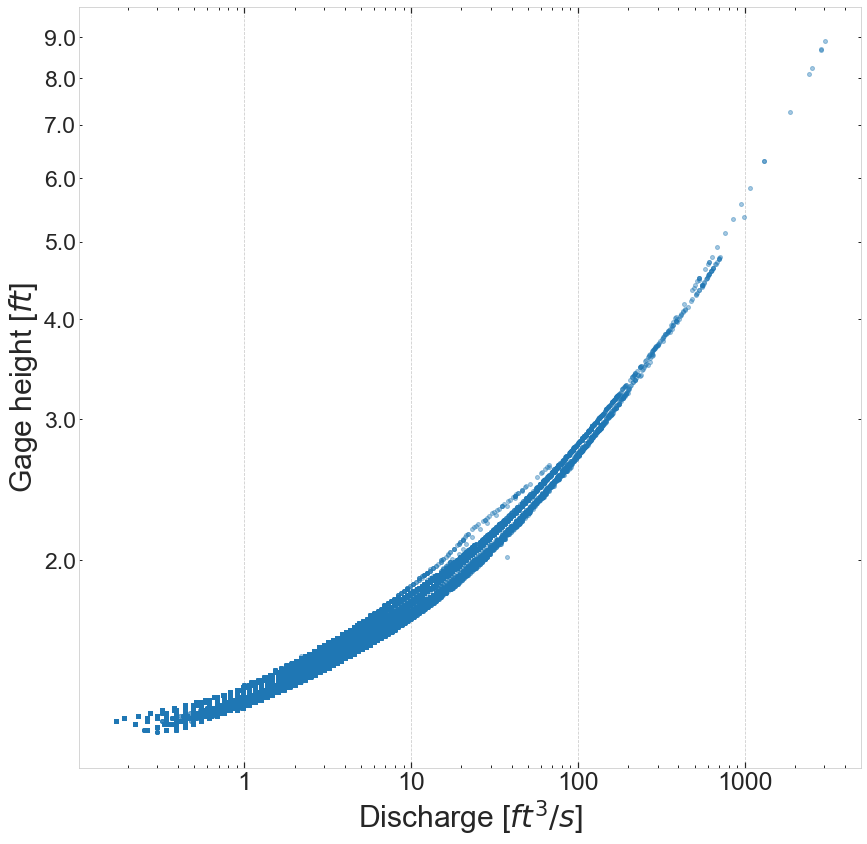

In [24]:
nrows = 1
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*14, nrows*14))

axisticksize = 25
axislabelsize = 30
scattersize = 4

axes.scatter(data['69679_00060'].values, data['69680_00065'].values,
             c='tab:blue', s=scattersize**2, alpha=0.4)

axes.set_xscale('log')
axes.set_yscale('log')

axes.set_xlabel('Discharge [$ft^{3}/s$]', fontsize=axislabelsize)
axes.set_ylabel('Gage height [$ft$]', fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axisticksize)
axes.tick_params(axis='both', which='minor', labelsize=axisticksize-2)

# Turn off scientific notations, which looked here "unbearingly" retarded
# Pretty much helpful thread:
#   - https://stackoverflow.com/questions/21920233/
axes.xaxis.set_major_formatter(mticker.ScalarFormatter())
axes.yaxis.set_major_formatter(mticker.ScalarFormatter())
axes.yaxis.set_minor_formatter(mticker.ScalarFormatter())

plt.show()

## Excercise 4

In case of small streams, storms and passing weather fronts with rain can significantly increase water discharge on a short time scale. Develop a simple algorithm to detect rainy events in the data. Plot the original time series and mark rainy events.

Sadly this works very poorly :(

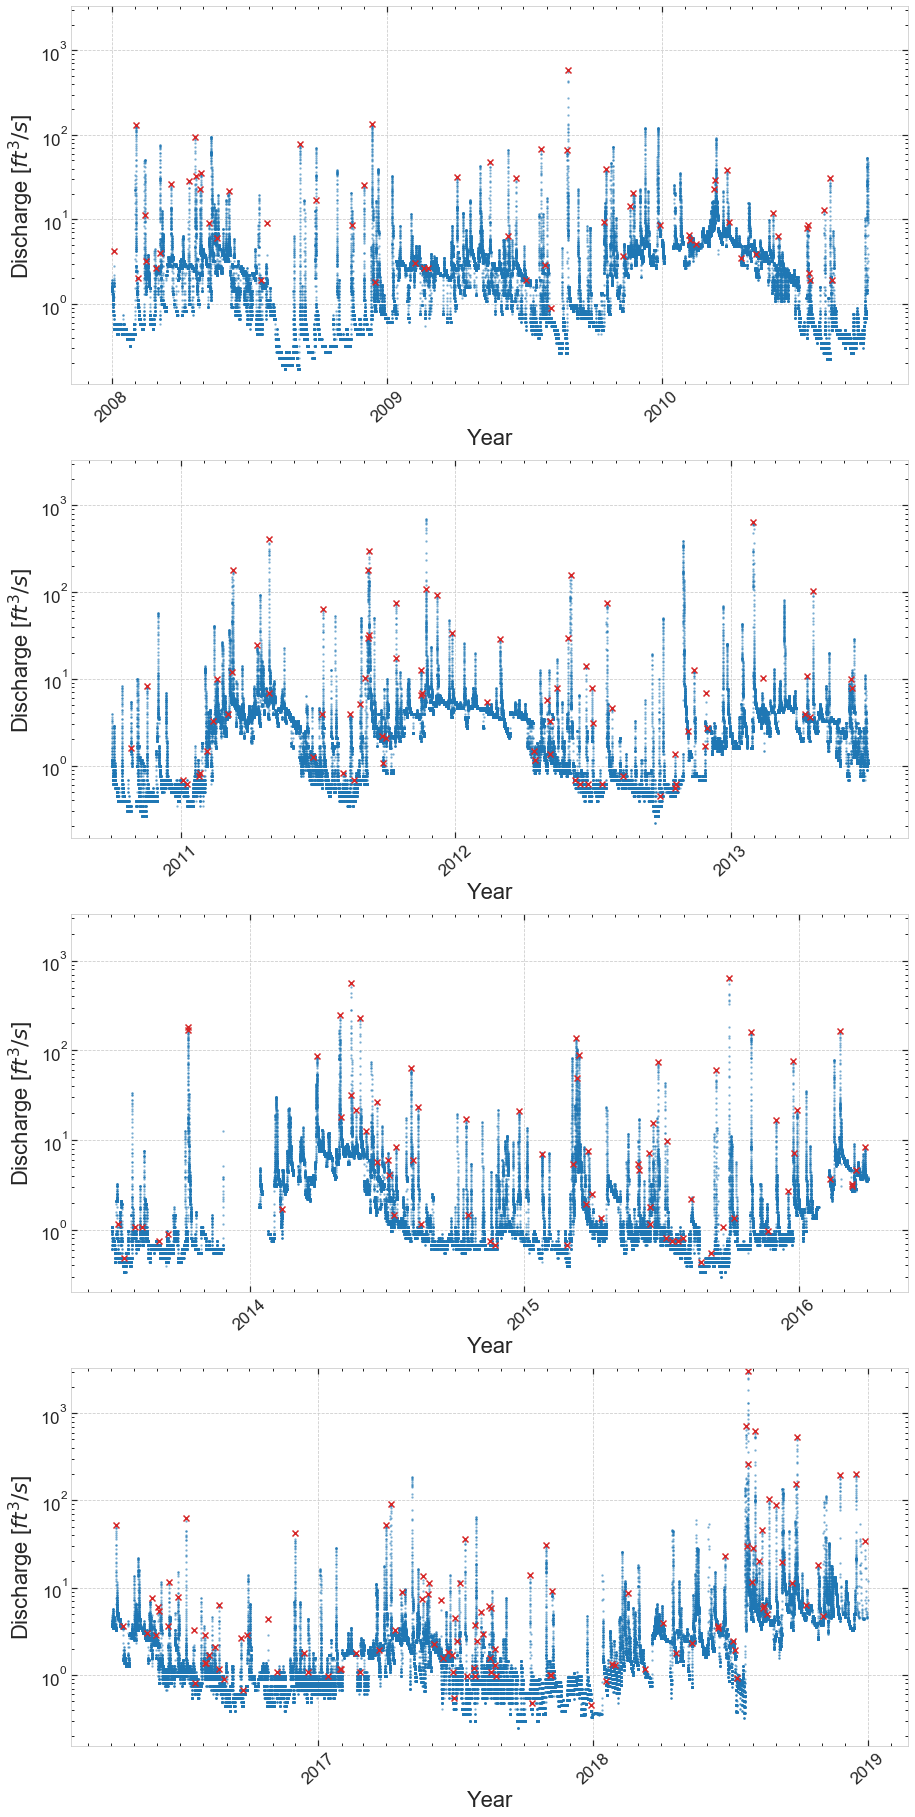

In [67]:
nrows = 4
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*15, nrows*8))

axisticksize = 17
axislabelsize = 22
scattersize = 1.5

dt = data['datetime'].max() - data['datetime'].min()
ts0 = data['datetime'].min()
split = dt//nrows

for i in range(nrows):
    tsB = ts0 + i * split
    tsE = ts0 + (i+1) * split
    current_data = data[(data.datetime >= tsB) & (data.datetime < tsE)]
    axes[i].scatter(current_data['datetime'], current_data['69679_00060'],
                    c='tab:blue', s=scattersize**2, alpha=0.4)
    
    # Calculate local maximums and plot them on the axis
    # with scipy's 'argrelextrema' function
    maxima_indeces = argrelextrema(current_data['69679_00060'].values, np.greater, order=20)
    maxima_dates = current_data['datetime'].iloc[maxima_indeces[0]]
    maxima_discharges = current_data['69679_00060'].iloc[maxima_indeces[0]]
    axes[i].scatter(maxima_dates, maxima_discharges,
                    marker='x', c='tab:red', s=(4*scattersize)**2, alpha=1.0)
    
    axes[i].set_yscale('log')
    axes[i].set_ylim(None, 1.1 * data['69679_00060'].max())

    axes[i].set_xlabel('Year', fontsize=axislabelsize)
    axes[i].set_ylabel('Discharge [$ft^{3}/s$]', fontsize=axislabelsize)
    axes[i].tick_params(axis='both', which='major', labelsize=axisticksize)

    # Rotate dates on axis
    axes[i].tick_params(axis='x', which='major', rotation=42)
    
    # DATE FORMATTING SOURCE:
    #   - https://matplotlib.org/gallery/text_labels_and_annotations/date.html
    # Format the ticks by calling the locator instances of matplotlib.dates
    # These locators should be called for every axis, that's why
    # they're placed inside this loop
    axes[i].xaxis.set_major_locator(mdates.YearLocator())
    axes[i].xaxis.set_major_formatter(years_fmt)
    axes[i].xaxis.set_minor_locator(mdates.MonthLocator())

plt.show()

## Excercise 5

Water discharge increases significantly during rain producing maxima in the time series. Plot the distribution of maximum values and fit with an appropriate function. Bring arguments to support the choice of probabilistic model.

## Excercise 6

Once rainy events are detected, plot the distribution of the length of sunny intervals between rains. Fit the distribution with an appropriate function.

## Excercise 7

What is the maximum of water discharge in an arbitrarily chosen period of one year? Calculate the maximum of water discharge due to rain in a rolling window of 1 year, plot its distribution and fit with an appropriate function.

In [15]:
# Calculate full time interval for rolling windows
dt = datetime.timedelta(days=365)
# Cut last 365 day period from original dataset
fw_data = data[(data['datetime'] < data['datetime'].max() - dt)][::100]
num_points = len(fw_data)

# Values to store maximum values in windows
max_data = np.zeros(num_points)

for idx, row_idx in enumerate(fw_data.index):
    t_0 = fw_data.loc[row_idx]['datetime']
    t_1 = t_0 + dt
    current_data = fw_data[(fw_data.datetime >= t_0) & (fw_data.datetime < t_1)]
    max_data[idx] = np.max(current_data['69680_00065'].values)

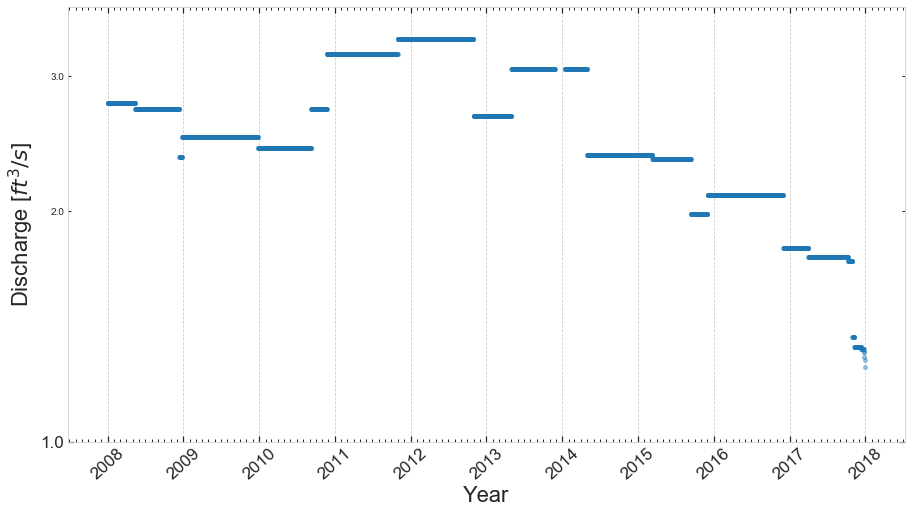

In [19]:
nrows = 1
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*15, nrows*8))

axisticksize = 17
axislabelsize = 22

axes.scatter(fw_data['datetime'], max_data,
                c='tab:blue', s=scattersize**2, alpha=0.4)
axes.set_yscale('log')
axes.set_ylim(1, 1.1 * fw_data['69680_00065'].max())

axes.set_xlabel('Year', fontsize=axislabelsize)
axes.set_ylabel('Discharge [$ft^{3}/s$]', fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axisticksize)

# Rotate dates on axis
axes.tick_params(axis='x', which='major', rotation=42)

# DATE FORMATTING SOURCE:
#   - https://matplotlib.org/gallery/text_labels_and_annotations/date.html
# Format the ticks by calling the locator instances of matplotlib.dates
axes.xaxis.set_major_locator(mdates.YearLocator())
axes.xaxis.set_major_formatter(years_fmt)
axes.xaxis.set_minor_locator(mdates.MonthLocator())

# Turn off scientific notations, which looked here unbearingly retarded
# Pretty much helpful thread:
#   - https://stackoverflow.com/questions/21920233/
axes.yaxis.set_major_formatter(mticker.ScalarFormatter())
axes.yaxis.set_minor_formatter(mticker.ScalarFormatter())

plt.show()

## Excercise 8

How many time does it rain in a month? Calculate and plot the distribution and fit with an appropriate function.

## Excercise 9

Find the measuring station you used in the excercises above on the map. Find another measurement station about 100-200 miles from it and download the data. Try to estimate the typical time it takes for weather fronts to travel the distance between the two measuring stations.